# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

## Questions:

    a) Dimensions of max function in MaxSim method function.
        - max of column vectors in matrix OR max of row vectors in columns --> 24 dimensional
    b) Training of my ColBERT model
        - [Q] and [D] in vocabulary --> Drop
        - Weights in additional linear layer of 32
        - [MASK] as padding instead of [PAD]
    c) How to save:
        The model (in github) --> Drop
        The document embeddings
        


In [1]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


In [3]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(f'Running on {device} with {n_gpu} number of GPUs')
else:
    print(f'Running on {device}. Be patient...')

Running on cpu. Be patient...


In [82]:
# add special ColBERT tokens to queries and documents
queries = ["[CLS] " + query + " [SEP]" for query in df['query']]

documents =  ["[CLS] " + query + " [SEP]" for query in df['documents']]

print("Example of query:\n", queries[0])
print("\nExample of document:\n", documents[0])

Example of query:
 [CLS] lede musikalsk personale [SEP]

Example of document:
 [CLS] Tildele og forvalte personaleopgaver på områder såsom instrumentering, bearbejdning, reproduktion af musik og stemmetræning. [SEP]


In [83]:
# Tokenize with BERT tokenizer
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

#tokenize queries
tokenized_texts = [tokenizer.tokenize(sent) for sent in queries]

# Tokenize documents
tokenized_docs = [tokenizer.tokenize(doc) for doc in documents]

print(f'Tokenize the first sentence: \n {tokenized_texts[0]}')
print (f'\nTokenize the first document: \n {tokenized_docs[0]}')

Tokenize the first sentence: 
 ['[CLS]', 'lede', 'musikalsk', 'personale', '[SEP]']

Tokenize the first document: 
 ['[CLS]', 'tildele', 'og', 'forvalt', '##e', 'personale', '##opgaver', 'pa', 'om', '##rad', '##er', 'sas', '##om', 'instrumenter', '##ing', ',', 'bearbejdning', ',', 'reproduktion', 'af', 'musik', 'og', 'stemme', '##træning', '.', '[SEP]']


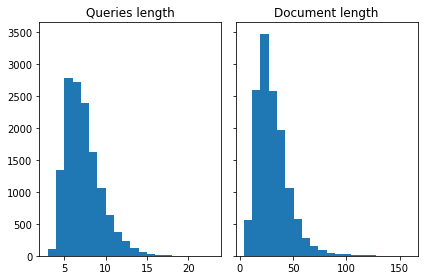

In [84]:
# Length of sequences
len_queries = [len(x) for x in tokenized_texts]
len_documents = [len(x) for x in tokenized_docs]

# Plot length of queries and documents
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(len_queries, bins=n_bins)
axs[0].set_title('Queries length',fontsize=12)
axs[1].hist(len_documents, bins=n_bins)
axs[1].set_title('Document length',fontsize=12)
plt.show()

Based on eye-balling the plot we determine to set maximum sequence length of queries to 24 and documents to 128

In [85]:
# Set the maximum query length. 
MAX_LEN_Q = 24

# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
q_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
q_input_ids = pad_sequences(q_input_ids, maxlen=MAX_LEN_Q, dtype="long", truncating="post", padding="post")
print(f'Shape of query ids:\n q_input_ids.shape = {q_input_ids.shape}')

Shape of query ids:
 q_input_ids.shape = (13485, 24)


In [86]:
# Create query attention masks
q_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in q_input_ids:
  seq_mask = [float(i>0) for i in seq]
  q_attention_masks.append(seq_mask)

print(f'Shape of query attention mask:\n q_attention_masks = {np.shape(q_attention_masks)}')

assert q_input_ids.shape == np.shape(q_attention_masks), 'dimensions of q_input_ids and q_attention_mask do not match' 

Shape of query attention mask:
 q_attention_masks = (13485, 24)


In [87]:
# Set the maximum document length. 
MAX_LEN_DOC = 128
# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
d_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_docs]
d_input_ids = pad_sequences(d_input_ids, maxlen=MAX_LEN_DOC, dtype="long", truncating="post", padding="post")
print(f'Shape of input_ids.shape: {d_input_ids.shape}')

Shape of input_ids.shape: (13485, 128)


In [88]:
# Create attention masks for documents
d_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in d_input_ids:
  seq_mask = [float(i>0) for i in seq]
  d_attention_masks.append(seq_mask)

print(f'Shape of d_attention_masks: {np.shape(d_attention_masks)}')

assert d_input_ids.shape == np.shape(d_attention_masks), 'dimensions of document d_input_ids and d_attention_mask do not match' 

Shape of d_attention_masks: (13485, 128)


# Import model
Queries and documents have now been tokenized to the vocabolary

In [89]:
from transformers import BertConfig
from transformers import BertModel

config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)

#param_optimizer = list(bert_base.named_parameters())
#print(bert_base)

In [90]:
from torch import nn
import torch.nn.functional as F

class SkillsColBERT(nn.Module):
    def __init__(self):
          super(SkillsColBERT, self).__init__()
          self.bert = bert_base 
          ### New layers:
          #TODO: 
          # self.finalLinear = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)
          

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids, attention_mask=mask) # sequence_output shape is: (batch_size, sequence_length, 768)
               
          # We apply the linear layer in line with ColBERT paper. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 32 numbers for every token
          # so the logits are of shape (batch_size, sequence_length, 32)
          
          #TODO: 
          # sequence_output = self.finalLinear(sequence_output)
          sequence_output = F.softmax(sequence_output, dim=1)

          return sequence_output

## Use Skills ColBERT model to embed the first X query and document pairs

In [91]:
# Try model on first X query and document pairs
sample_size = 30

#np.random.seed(seed=741)
#samples = np.random.randint(0,len(df),sample_size)

q_id    = torch.tensor(q_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
q_mask  = torch.tensor(np.array(q_attention_masks[:sample_size])).to(torch.device(device)).to(torch.int64)

d_id    = torch.tensor(d_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
d_mask  = torch.tensor(np.array(d_attention_masks[:sample_size])).to(torch.device(device)).to(torch.int64)

In [92]:
#bert_base.to(torch.device(device))
my_model  = SkillsColBERT()
my_model.to(torch.device(device))

# Embeddings of queries
q_outputs = my_model(q_id, mask=q_mask)

# Embeddings of documents
d_outputs = my_model(d_id, mask=d_mask)

#With bert_base shape is: torch.Size([batch_size, 24, 768]) and torch.Size([batch_size, 128, 768])
print('Query embedding size:    ', q_outputs.shape) 
print('Document embedding size: ', d_outputs.shape) 

Query embedding size:     torch.Size([30, 24, 768])
Document embedding size:  torch.Size([30, 128, 768])


In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. In my implementation of ColBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_d) = [ 128 \times 32]
\end{align*}

\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_D) = [13.485 \times 128 \times 32]
\end{align*}


The relevancy score, MaxSim, is defined as follows:

$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [93]:
def MaxSim(q, D):
    '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
        Return a tensor of the query's similarity scores to all documents in D.'''

    # repeat q for faster matrix multiplication (faster than loop)
    batch_size=D.shape[0]
    q_X = q.repeat(batch_size, 1, 1)
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.bmm(q_X, D.permute(0,2,1))
    
    maks, _ = torch.max(batch_mm, dim=2) # dim=1 or dim=2
    #print(maks.shape) # should be (batch_size, 24)
    
    # Sum over maximum values --> return vector of length len(D)
    S_qD = torch.sum(maks, dim=1)
    
    return S_qD

## Exampleof implementation

In [94]:
most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    S_qD = MaxSim(q, D)
    maks, maks_id = torch.max(S_qD, dim=0)

    most_similar_doc_score.append(float(maks))
    most_similar_docID.append(int(maks_id))

100%|██████████| 30/30 [00:00<00:00, 33.68it/s]


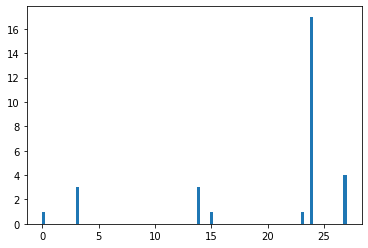

In [95]:
# Distribution of "predictions"
plt.hist(most_similar_docID, bins=100)
plt.show()

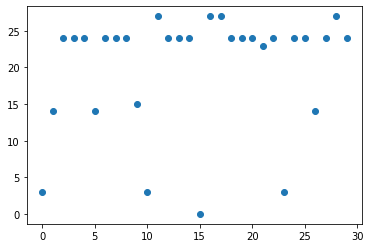

In [96]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, most_similar_docID)
plt.show()

In [97]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = most_similar_docID

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

f_1score:  0.0037


In [98]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

rights: 1 out of 30 
 0.033% accuracy


In [99]:
df_correct = df.iloc[:sample_size,:].loc[(np.array(y_true) == np.array(y_pred))]
df_correct

,query,documents
24,udnytte avancerede kliniske kompetencer,Anvende avancerede kliniske kompetencer i best...


In [81]:
# Inspect specific document. - Why are 49 and 79 getting this many hits. 
df.documents[79]

'Overvåge og vedligeholde boringsvæskerne eller "mudder". Tilføje forskellige kemikalier til væsken med henblik på at udføre forskellige funktioner i brøndoperationer: holde borebitten afkølet, hydrostatisk tryk, osv.'

## Benchmark
BERCH embedding Euclidean distance